# Concert Tickets Price Prediction - EDA and Regression 
#### By: Sarah Alabdulwahab & Asma Althakafi

>Our goal for this project is to predict the prices of the concert tickets of the upcoming concerts in America.

## Data Description 
After we obtained the datasets by scraping two websites: Razorgator and Wikipedia, these are the features for the concert tickets:
- **Artist**: A band or an individual that will perform live music.
- **Data**, which contains the following:
    - **City**: The city that the concert will occur in.
    - **State**: The state that the concert will occur in.
    - **Venue**: The venue that the concert will occur in.
    - **Date**: The date that the concert will occur on.
    - **Day**: The day that the concert will occur on.
    - **Time**: The time that the concert will occur at.
- **Level**: Front, middle, and last sections/rows.
- **Price**: The price of the concert ticket.

And these are the features for the salaries:
- **State**: The name of the state.
- **Median Salary**: The median salary of the corresponding state. 
- **Average Salary**: The average salary of the corresponding state. 

In [1]:
#imports
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt  
%matplotlib inline

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import (RandomForestRegressor, AdaBoostRegressor, BaggingClassifier,
                                RandomForestClassifier, AdaBoostClassifier)
from sklearn.neighbors import KNeighborsClassifier

## Cities Data

In [2]:
df_cities = pd.read_csv('Cities_lng_lat.csv')
df_cities.head(2)

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,New York,New York,NY,New York,36061,New York,40.6943,-73.9249,18713220,10715,polygon,False,True,America/New_York,1,11229 11226 11225 11224 11222 11221 11220 1138...,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1139,-118.4068,12750807,3276,polygon,False,True,America/Los_Angeles,1,90291 90293 90292 91316 91311 90037 90031 9000...,1840020491


In [3]:
df_cities_small = df_cities[['city','state_id', 'lat', 'lng','density', 'population']]
df_cities_small.columns = ['city','state', 'lat_city', 'lng_city','density', 'population']
df_cities_small.head()

,city,state,lat_city,lng_city,density,population
0,New York,NY,40.6943,-73.9249,10715,18713220
1,Los Angeles,CA,34.1139,-118.4068,3276,12750807
2,Chicago,IL,41.8373,-87.6862,4574,8604203
3,Miami,FL,25.7839,-80.2102,5019,6445545
4,Dallas,TX,32.7936,-96.7662,1526,5743938


## States Data

In [4]:
df_states_coor = pd.read_csv('State_lng_lat.csv')
df_states_coor.head()

,state,latitude,longitude,name
0,AK,63.588753,-154.493062,Alaska
1,AL,32.318231,-86.902298,Alabama
2,AR,35.201050,-91.831833,Arkansas
3,AZ,34.048928,-111.093731,Arizona
4,CA,36.778261,-119.417932,California


In [5]:
df_states_coor = df_states_coor[['state','latitude','longitude']]
df_states_coor.columns = ['state','lat_state','lng_state']
df_states_coor.head()

,state,lat_state,lng_state
0,AK,63.588753,-154.493062
1,AL,32.318231,-86.902298
2,AR,35.201050,-91.831833
3,AZ,34.048928,-111.093731
4,CA,36.778261,-119.417932


## Tickets Data

In [6]:
#reading file
df_tickets = pd.read_csv('tickets.csv')
df_tickets

,artist,data,level,price
0,Machine Gun Kelly,"Eagles Ballroom: Milwaukee, WI - Tue, Oct 05 2...",Section GA • Row GA1,$202
1,Machine Gun Kelly,"Eagles Ballroom: Milwaukee, WI - Tue, Oct 05 2...",VIP BALC • Row GA,$278
2,Machine Gun Kelly,"Eagles Ballroom: Milwaukee, WI - Tue, Oct 05 2...",VIP BALC • Row GA,$291
3,Machine Gun Kelly,"Eagles Ballroom: Milwaukee, WI - Tue, Oct 05 2...",FLOOR GA • Row GA1,$370
4,Machine Gun Kelly,"Ascend Amphitheater: Nashville, TN -\nWed, Oct...",GA Pit • Row GA0,$394
...,...,...,...,...
180089,Dave Chappelle,"Smoothie King Center: New Orleans, LA -\nThu, ...",Section 113 • Row 5,$438
180090,Dave Chappelle,"Smoothie King Center: New Orleans, LA -\nThu, ...",Section 302 • Row 8,$152
180091,Dave Chappelle,"Smoothie King Center: New Orleans, LA -\nThu, ...",Section 301 • Row 1,$209
180092,Dave Chappelle,"Smoothie King Center: New Orleans, LA -\nThu, ...",Section 108 • Row 11,$250


In [7]:
df_tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180094 entries, 0 to 180093
Data columns (total 4 columns):
artist    180094 non-null object
data      180094 non-null object
level     180094 non-null object
price     180094 non-null object
dtypes: object(4)
memory usage: 5.5+ MB


In [8]:
#drop the dublicate rows, because it could produce inaccurate predictions
df_tickets.drop_duplicates(subset = ['artist','data','level'], keep = False, inplace = True)
df_tickets

,artist,data,level,price
0,Machine Gun Kelly,"Eagles Ballroom: Milwaukee, WI - Tue, Oct 05 2...",Section GA • Row GA1,$202
3,Machine Gun Kelly,"Eagles Ballroom: Milwaukee, WI - Tue, Oct 05 2...",FLOOR GA • Row GA1,$370
5,Machine Gun Kelly,"Ascend Amphitheater: Nashville, TN -\nWed, Oct...",GA Pit • Row GAO,$407
6,Machine Gun Kelly,"Ascend Amphitheater: Nashville, TN -\nWed, Oct...",GA Pit • Row GA2,$407
13,Machine Gun Kelly,"Ascend Amphitheater: Nashville, TN -\nWed, Oct...",Section 101 • Row ADA,$225
...,...,...,...,...
180088,Dave Chappelle,"Smoothie King Center: New Orleans, LA -\nThu, ...",Section 310 • Row 14,$98
180089,Dave Chappelle,"Smoothie King Center: New Orleans, LA -\nThu, ...",Section 113 • Row 5,$438
180090,Dave Chappelle,"Smoothie King Center: New Orleans, LA -\nThu, ...",Section 302 • Row 8,$152
180091,Dave Chappelle,"Smoothie King Center: New Orleans, LA -\nThu, ...",Section 301 • Row 1,$209


### Exploring and Cleaning the Artist Feature

In [9]:
df_tickets['artist'].unique()

array(['Machine Gun Kelly', 'Run the Jewels', 'J. Cole', '21 Savage',
       'Post Malone', 'Doja Cat', 'Tyler The Creator', 'Travis Scott',
       'Jack Harlow', 'Megan Thee Stallion', 'DaBaby', 'ATLiens',
       'DJ Diesel', 'Z-Trip', 'The Martinez Brothers', 'Tsuruda',
       'Pitbull', 'Don Toliver', 'Russ', 'Saint Jhn', 'T-Pain', '50 Cent',
       'Ying Yang Twins', 'Lil Baby', 'Lil Durk', 'Elton John',
       'Billie Eilish', 'Joan Jett And The Blackhearts', 'Poison',
       'The Stadium Tour', 'Motley Crue', 'Def Leppard', 'Harry Styles',
       'The Rolling Stones', 'Ashley McBryde', 'BTS - Bangtan Boys',
       'Justin Bieber', 'Billy Joel', 'Dead & Company', 'Genesis',
       'Dua Lipa', 'Celine Dion', 'James Taylor', 'Rammstein',
       'The Eagles', 'John Mayer', 'Jackson Browne', 'Lady Gaga',
       'Backstreet Boys', 'Luke Combs', 'Kenny Chesney', 'Drew Parker',
       'Garth Brooks', 'Ray Fulcher', 'Chris Stapleton', 'George Strait',
       'Kane Brown', 'Eric Church', '

In [10]:
#removing festivals
df_tickets = df_tickets[(df_tickets['artist'] != 'Aftershock Festival') & (df_tickets['artist'] != 'ATLive') & (df_tickets['artist'] != 'The Stadium Tour') & (df_tickets['artist'] != 'CMA Music Festival')]

In [11]:
len(df_tickets['artist'].unique())

92

### Exploring and Cleaning the Data Feature

In [12]:
#clean the data feature: extract the venue, city, state, day, date, and time
venues = []
cities = []
states = []
dates = []
times = []

for x in df_tickets['data']:
    # for example, x is 'Rocket Mortgage FieldHouse: Cleveland, OH -\nSat, Dec 18 2021 7:30 PM\n'
    x = x.strip().replace('\n', ' ')
    times.append(x[-8:].strip())
    
    # txt is['Rocket Mortgage FieldHouse', 'Cleveland, OH - Sat, Dec 18 2021 7', '30 PM']
    txt = x.split(':')
    venues.append(txt[0].strip())
    
    #txt[1] is 'Cleveland, OH - Sat, Dec 18 2021 7'
    #txt2 is ['Cleveland', ' OH - Sat', 'Dec 18 2021 7']
    txt2 = txt[1].split(',')
    cities.append(txt2[0].strip())
    states.append(txt2[1][:3].strip())
        
    if len(txt2) == 3:
        dates.append(txt2[2][:12].strip())
    else:
        dates.append('TBD')

In [13]:
#store lists to df_tickets
df_tickets['venue'] = venues
df_tickets['city'] = cities
df_tickets['state'] = states
df_tickets['date'] = dates 
df_tickets['time'] = times

In [14]:
#print all unique values
df_tickets['venue'].unique()

array(['Eagles Ballroom', 'Ascend Amphitheater',
       'Bill Graham Civic Auditorium', 'Pavilion at Riverfront',
       'McMenamins Historic Edgefield Amphitheater', 'Greek Theatre',
       'The Theater at Virgin Hotels - Las Vegas',
       'The Lot at The Complex', 'Red Rocks Amphitheatre',
       'Shrine LA Outdoors', 'Mesa Amphitheatre', 'Mardi Gras World',
       'Oklahoma City Zoo Amphitheatre',
       'The Pavilion at Toyota Music Factory',
       'Charlotte Metro Credit Union Amphitheatre at the AvidXchange Music Factory',
       'Virginia Credit Union LIVE! at Richmond Raceway',
       'Petersen Events Center', 'Mohegan Sun Arena',
       'Rocket Mortgage FieldHouse', 'Don Haskins Center',
       'Pan American Center', 'Gila River Arena', 'Oakland Arena',
       'Tacoma Dome', 'Moda Center at the Rose Quarter',
       'Pacific Coliseum', 'Rogers Place', 'Scotiabank Saddledome',
       'Bell MTS Place', 'Denny Sanford Premier Center', 'Target Center',
       'T-Mobile Center', 

In [15]:
df_tickets['city'].unique()

array(['Milwaukee', 'Nashville', 'San Francisco', 'Spokane', 'Troutdale',
       'Los Angeles', 'Las Vegas', 'Salt Lake City', 'Morrison', 'Mesa',
       'New Orleans', 'Oklahoma City', 'Irving', 'Charlotte', 'Richmond',
       'Pittsburgh', 'Uncasville', 'Cleveland', 'El Paso', 'Las Cruces',
       'Glendale', 'Oakland', 'Tacoma', 'Portland', 'Vancouver',
       'Edmonton', 'Calgary', 'Winnipeg', 'Sioux Falls', 'Minneapolis',
       'Kansas City', 'St. Louis', 'Detroit', 'East Troy', 'Chicago',
       'Hamilton', 'Toronto', 'Buffalo', 'Raleigh', 'Washington',
       'New York', 'Houston', 'Dallas', 'Denver', 'Phoenix', 'Inglewood',
       'Philadelphia', 'Flushing', 'San Bernardino', 'Memphis',
       'Arlington', 'Gulf Shores', 'Fort Worth', 'Rosemont', 'Boston',
       'Atlanta', 'Sunrise', 'San Diego', 'Independence', 'Columbus',
       'Worcester', 'Norfolk', 'Laval', 'Orlando', 'Tampa', 'Miami',
       'North Charleston', 'Duluth', 'Sacramento', 'Seattle', 'Rochester',
       'In

In [16]:
df_tickets['state'].unique()

array(['WI', 'TN', 'CA', 'WA', 'OR', 'NV', 'UT', 'CO', 'AZ', 'LA', 'OK',
       'TX', 'NC', 'VA', 'PA', 'CT', 'OH', 'NM', 'BC', 'AB', 'MB', 'SD',
       'MN', 'MO', 'MI', 'IL', 'ON', 'NY', 'DC', 'AL', 'MA', 'GA', 'FL',
       'QC', 'SC', 'IN', 'MS', 'NJ', 'MD', 'KY', 'AR', 'KS', 'NE', 'GL',
       'ND', 'IA', 'JA', 'CD', 'SK', 'ID', 'MT', 'NH', 'WV', 'DE'],
      dtype=object)

In [17]:
df_tickets['date'].unique()

array(['Oct 05 2021', 'Oct 06 2021', 'Oct 10 2021', 'Oct 12 2021',
       'Oct 13 2021', 'Oct 15 2021', 'Oct 16 2021', 'Oct 17 2021',
       'Oct 18 2021', 'Oct 20 2021', 'Oct 21 2021', 'Oct 22 2021',
       'Oct 23 2021', 'Oct 24 2021', 'Oct 27 2021', 'Oct 28 2021',
       'Oct 30 2021', 'Oct 31 2021', 'Dec 18 2021', 'Mar 31 2022',
       'Apr 02 2022', 'Apr 04 2022', 'Apr 06 2022', 'Apr 26 2022',
       'Apr 28 2022', 'Apr 30 2022', 'May 02 2022', 'May 05 2022',
       'May 07 2022', 'May 09 2022', 'May 11 2022', 'May 13 2022',
       'May 15 2022', 'May 16 2022', 'May 18 2022', 'May 20 2022',
       'May 22 2022', 'May 23 2022', 'Jul 09 2022', 'Jul 11 2022',
       'Jul 12 2022', 'Jul 19 2022', 'Jul 21 2022', 'Jul 23 2022',
       'Jul 25 2022', 'Jul 27 2022', 'Jul 29 2022', 'Jul 31 2022',
       'Aug 02 2022', 'Aug 03 2022', 'Aug 08 2022', 'Aug 09 2022',
       'Aug 11 2022', 'Aug 12 2022', 'Aug 14 2022', 'Oct 07 2021',
       'Oct 11 2021', 'Oct 14 2021', 'Oct 25 2021', 'Dec 10 20

In [18]:
df_tickets['time'].unique()

array(['7:30 PM', '8:00 PM', '6:30 PM', '6:00 PM', '2021 TBD', '7:00 PM',
       '2022 TBD', '5:00 PM', '2070 TBD', 'ostponed', '12:00 PM',
       '8:30 PM', '4:30 PM', '10:00 AM', '11:00 AM', '4:00 PM',
       '12:00 AM', '10:00 PM', '9:30 PM', '9:00 PM', '8:45 PM'],
      dtype=object)

In [19]:
#remove the less occuring venues
df_tickets = df_tickets[df_tickets['venue'].map(df_tickets['venue'].value_counts() >= 500)]

In [20]:
#excluding incorrect values
df_tickets = df_tickets[(df_tickets.date != 'TBD')]
df_tickets = df_tickets[(df_tickets.time != '2021 TBD') & (df_tickets.time != '2070 TBD') 
                        & (df_tickets.time != '2022 TBD') & (df_tickets.time != 'ostponed')] #postponed

In [21]:
df_tickets.date = pd.to_datetime(df_tickets.date)

df_tickets['month'] = df_tickets.date.dt.month
df_tickets['year'] = df_tickets.date.dt.year
df_tickets['day'] = df_tickets.date.dt.weekday #monday is 0

df_tickets.time = pd.to_datetime(df_tickets.time).dt.hour

In [22]:
#drop columns data and date
df_tickets.drop(columns = ['data','date'], inplace = True)

### Exploring and Cleaning the Level Feature

In [23]:
#clean the levels, try to unify them
new_level = []
for lev in tqdm(df_tickets['level'].str.upper()):
    lev = lev.strip()
    if 'DAY' in lev or 'RESERVED' in lev or 'PACKAGE' in lev or 'TBD' in lev:
        new_level.append('drop') #making it easier to drop later
        continue
    elif 'VIP' in lev:
        new_level.append('VIP')
    elif 'GA' in lev or 'General Admission'.upper() in lev or 'G.A' in lev or 'GENADM' in lev or 'G/A' in lev:
        new_level.append('GA')
    elif 'CENTER' in lev:
        new_level.append('CENTER')
    elif 'LEFT' in lev or 'LFT' in lev:
        new_level.append('LEFT')
    elif 'RIGHT' in lev:
        new_level.append('RIGHT')
    elif 'LAWN' in lev:
        new_level.append('LAWN')
    elif 'TERRACE' in lev:
        new_level.append('TERRACE')
    elif 'BALCONY' in lev or 'BAL' in lev:
        new_level.append('BALCONY')
    elif 'BENCH' in lev:
        new_level.append('BENCH')
    elif 'FLOOR' in lev or 'FLR' in lev or 'FL' in lev:
        new_level.append('FLOOR')
    elif 'SUITE' in lev:
        new_level.append('SUITE')
    elif 'UPPER' in lev or 'UR' in lev:
        new_level.append('UPPER')
    elif 'LOWER' in lev or 'LR' in lev:
        new_level.append('LOWER')
    elif 'LOGE' in lev:
        new_level.append('LOGE')
    elif 'GROUND' in lev:
        new_level.append('GROUND')
    elif 'CON' in lev:
        new_level.append('CONCOURSE')
    elif 'RISERS' in lev:
        new_level.append('RISERS')
    elif 'MEZ' in lev:
        new_level.append('MEZZANINE')
    elif 'ORCHESTRA' in lev or 'ORCH' in lev:
        new_level.append('ORCHESTRA')
    elif 'STADIUM' in lev:
        new_level.append('STADIUM')
    elif 'PAVILLION' in lev:
        new_level.append('PAVILLION')
    elif 'TABL' in lev:
        new_level.append('TABLE')
    elif 'GRAND SALLE' in lev:
        new_level.append('GRAND SALLE')
    elif 'PIT' in lev:
        new_level.append('PIT')
    elif 'PLAT' in lev:
        new_level.append('PLATINUM')
    elif 'GRAND' in lev:
        new_level.append('GRAND')
    elif 'DIAMOND' in lev:
        new_level.append('DIAMOND')
    elif 'CLUB' in lev or 'CLB' in lev:
        new_level.append('CLUB')
    elif 'BLEACHERS' in lev:
        new_level.append('BLEACHERS')
    elif 'BOX' in lev:
        new_level.append('BOX')
    elif 'PR' in lev:
        new_level.append('PR')
    elif 'SECTION' in lev or 'FIELD' in lev:
        val = lev.split()[1].strip()
        if 'SEC' in val or 'PART' in val:
            new_level.append(val[-1])
        elif val.isnumeric():
            #check for leading zeros
            if val[0] == '0':
                val = val[1:]
            #split into ranges
            if int(val) in range(1,100):
                new_level.append('level-0')
            elif int(val) in range(100,200):
                new_level.append('level-1')
            elif int(val) in range(200,300):
                new_level.append('level-2')
            elif int(val) in range(300,400):
                new_level.append('level-3')
            elif int(val) in range(400,500):
                new_level.append('level-4')
            elif int(val) in range(500,600):
                new_level.append('level-5')
            elif int(val) in range(600,700):
                new_level.append('level-6')
            else:
                new_level.append('level-7')
        elif val.isalpha():
            if len(val) == 2 and val[0] == val[1]:
                new_level.append(val[0])
            else:
                new_level.append(val)
        else: 
            chars = ''
            for char in val:
                if char.isalpha():
                    chars += char
            new_level.append(chars)
    else:
        new_level.append('OTHER')

100%|██████████| 62000/62000 [00:00<00:00, 90361.41it/s]


In [24]:
#store list to df_tickets
df_tickets['level'] = new_level

In [25]:
#drop the leveles we excluded
df_tickets = df_tickets[df_tickets['level'] != 'drop']

In [26]:
df_tickets['level'].nunique()

62

In [27]:
df_tickets['level'].value_counts()[:50]

level-1      24300
level-2      11642
level-3       8647
level-0       4332
FLOOR         1692
level-4       1185
GA             915
C              913
ORCHESTRA      716
MEZZANINE      575
A              540
BALCONY        539
level-5        479
F              455
LOGE           428
UPPER          407
TERRACE        406
PR             360
B              321
LOWER          304
M              279
OTHER          240
D              235
BOX            233
E              205
V              154
GRAND          128
G              122
CL             111
H               92
SUITE           88
J               83
K               79
RIGHT           78
VIP             77
P               69
L               63
PIT             51
N               51
Q               40
CLUB            36
T               34
U               33
LEFT            22
R               21
CB              21
W               17
S                9
SL               9
DRM              8
Name: level, dtype: int64

In [28]:
df_tickets = df_tickets[df_tickets['level'] != '']

### Exploring and Cleaning the Price Feature

In [29]:
df_tickets['price'].head()

1011    $138
1012    $147
1014    $157
1017    $142
1019    $221
Name: price, dtype: object

In [30]:
#remove dolar sign and convert it to float
df_tickets['price'] = df_tickets['price'].str.replace('$',"").str.replace(",","").astype(float)

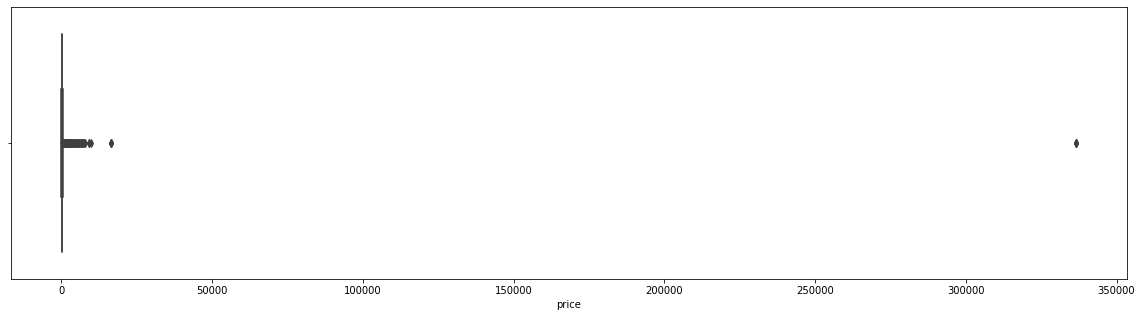

In [31]:
#checking for outliers
plt.figure(figsize=(20,5))
sns.boxplot("price", data=df_tickets);

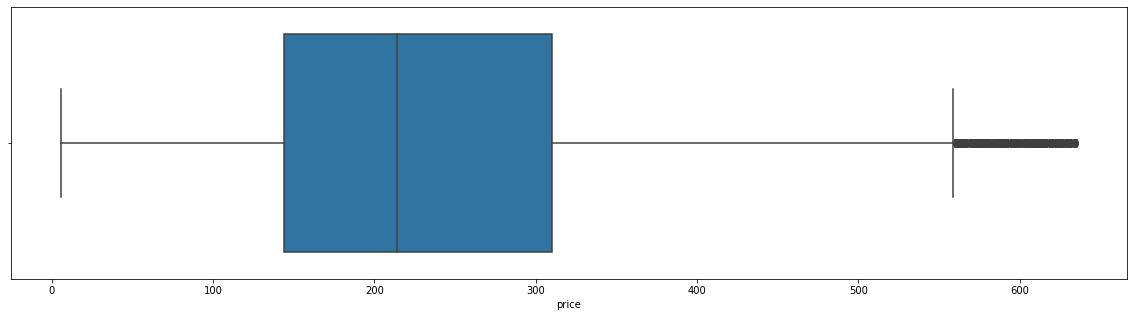

In [32]:
plt.figure(figsize=(20,5))
Q1 = df_tickets['price'].quantile(0.25)
Q3 = df_tickets['price'].quantile(0.75)
IQR = Q3 - Q1 
sns.boxplot("price", data=df_tickets.loc[(df_tickets['price'] >= Q1 - 1.5 * IQR) 
                                         & (df_tickets['price'] <= Q3 + 1.5 *IQR)]);

In [33]:
df_tickets = df_tickets.loc[(df_tickets['price'] >= Q1 - 1.5 * IQR) & (df_tickets['price'] <= Q3 + 1.5 *IQR)]
df_tickets

,artist,level,price,venue,city,state,time,month,year,day
1011,Machine Gun Kelly,level-0,138.0,Mohegan Sun Arena,Uncasville,CT,19,10,2021,6
1012,Machine Gun Kelly,level-0,147.0,Mohegan Sun Arena,Uncasville,CT,19,10,2021,6
1014,Machine Gun Kelly,level-0,157.0,Mohegan Sun Arena,Uncasville,CT,19,10,2021,6
1017,Machine Gun Kelly,level-0,142.0,Mohegan Sun Arena,Uncasville,CT,19,10,2021,6
1019,Machine Gun Kelly,level-0,221.0,Mohegan Sun Arena,Uncasville,CT,19,10,2021,6
...,...,...,...,...,...,...,...,...,...,...
180088,Dave Chappelle,level-3,98.0,Smoothie King Center,New Orleans,LA,20,10,2021,3
180089,Dave Chappelle,level-1,438.0,Smoothie King Center,New Orleans,LA,20,10,2021,3
180090,Dave Chappelle,level-3,152.0,Smoothie King Center,New Orleans,LA,20,10,2021,3
180091,Dave Chappelle,level-3,209.0,Smoothie King Center,New Orleans,LA,20,10,2021,3


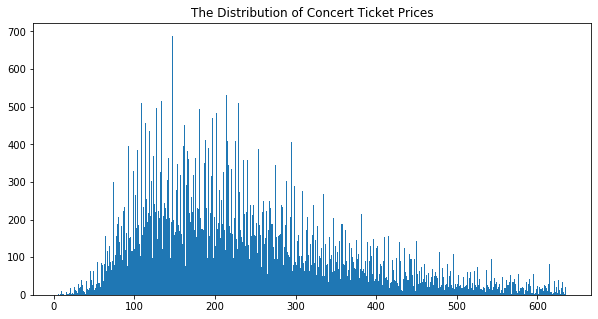

In [34]:
plt.figure(figsize=(10,5))
plt.hist(df_tickets.price, bins=500)
plt.title('The Distribution of Concert Ticket Prices');

### EDA & Visualization of the Tickets Dataset

In [35]:
#defining colors
blue = sns.color_palette()[0]
orange = sns.color_palette()[1]
pink = sns.color_palette()[6]

#### Ticket Prices per Day
It is evident that during the weekend the price range is higher than during the weekdays.

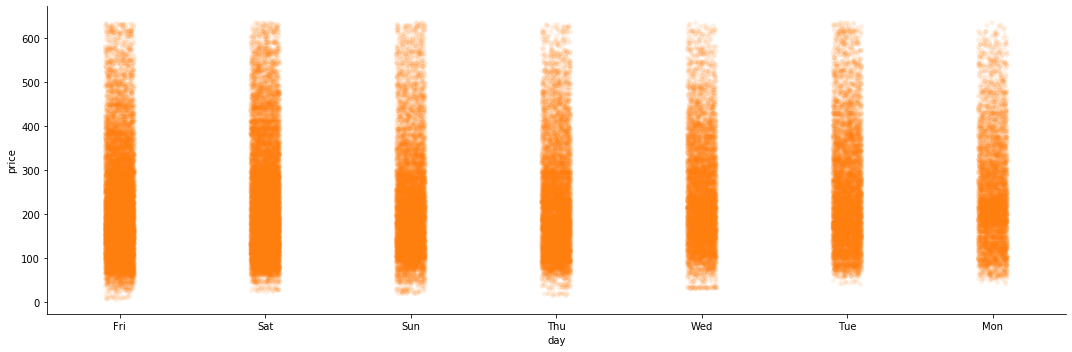

In [36]:
day_order = df_tickets.day.value_counts().index
sns.catplot(y='price', x='day', data=df_tickets, color= orange, height=5, aspect=3, alpha=0.1, order=day_order);
plt.xticks([0,1,2,3,4,5,6], ['Fri','Sat','Sun','Thu','Wed','Tue','Mon']); #ordered

#### Ticket Prices per Artist per Day
It is not very interpretable because the data is too huge, however, it is evident that Friday, Saturday, and Sunday are the most occuring

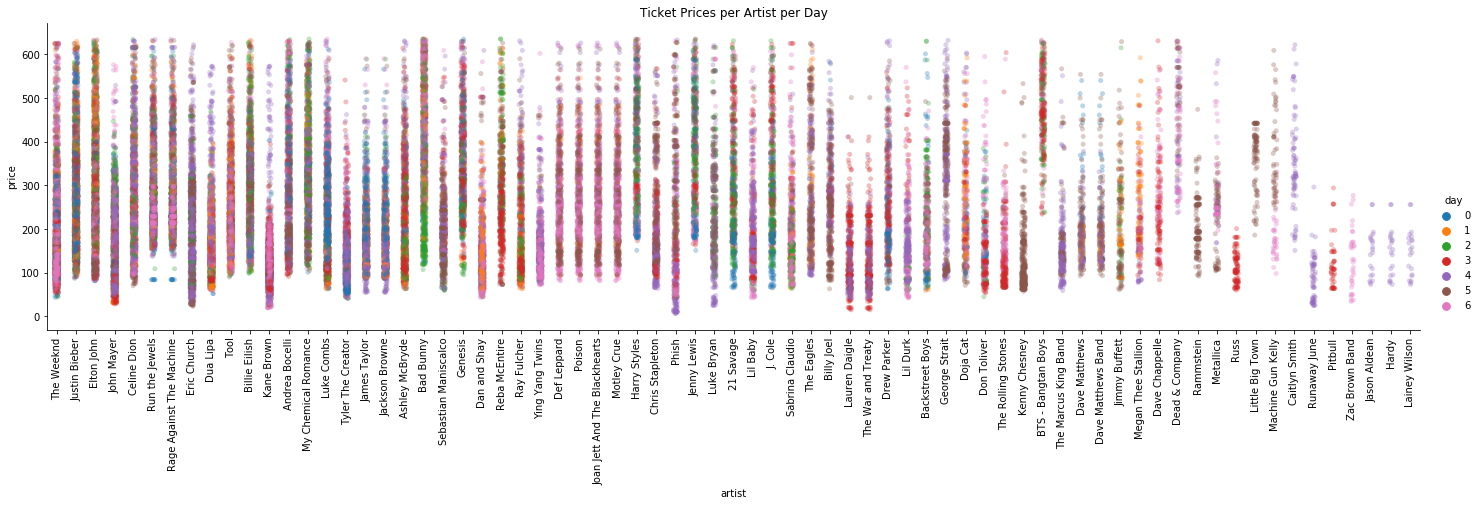

In [37]:
artist_order = df_tickets.artist.value_counts().index
sns.catplot(y='price', x='artist', hue='day', data=df_tickets, height=5, aspect=4, alpha=0.3, order=artist_order)
plt.xticks(rotation='90')
plt.title('Ticket Prices per Artist per Day');

#### Ticket Prices per Venue
It is evident that the price range varies across most venues.

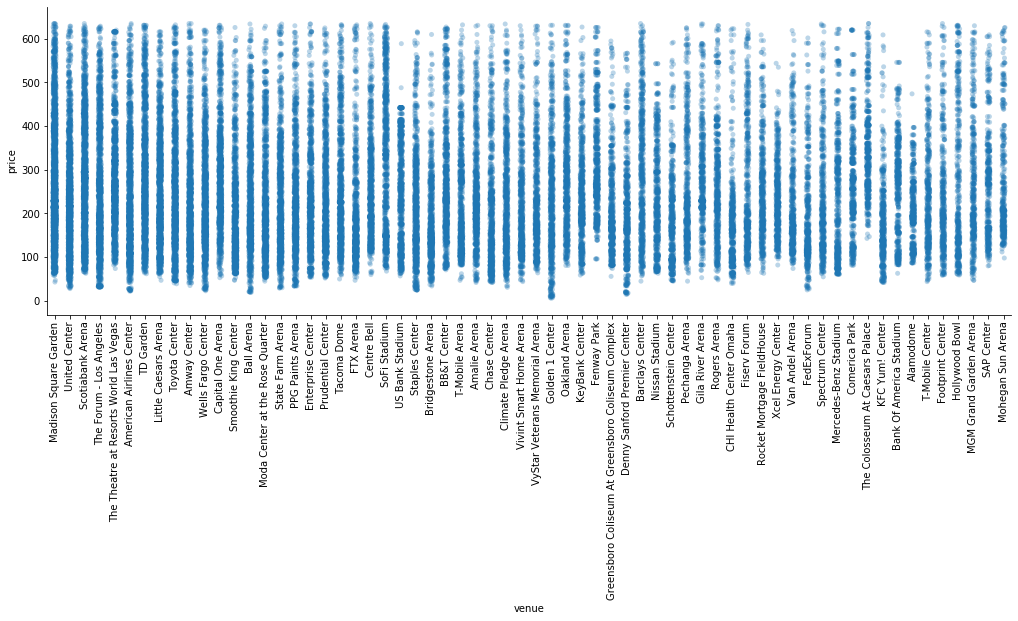

In [38]:
venue_order = df_tickets.venue.value_counts().index
sns.catplot(y='price', x='venue', data=df_tickets, color= blue, alpha=0.3,
            height=5, aspect=3, order=venue_order);
plt.xticks(rotation='90');

#### Top 10 Artists with the Highest Average Ticket Price

In [39]:
df_artist = df_tickets.groupby('artist').mean()['price'].sort_values(ascending=False)
df_artist.head()

artist
BTS - Bangtan Boys    475.080000
Dead & Company        441.317568
Bad Bunny             382.346354
Harry Styles          379.690828
Jenny Lewis           365.770627
Name: price, dtype: float64

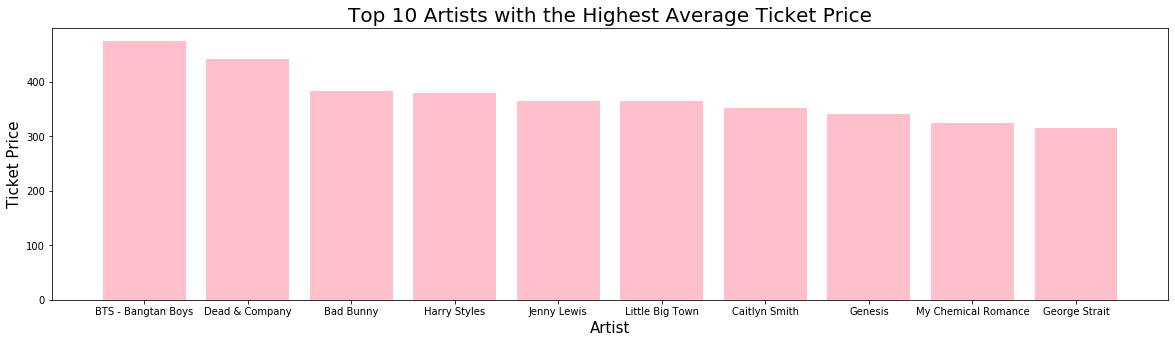

In [40]:
plt.figure(figsize=(20,5))
plt.bar(x=df_artist.index[:10], height=df_artist[:10], color='pink')
plt.xlabel('Artist', fontsize=15)
plt.ylabel('Ticket Price', fontsize=15)
plt.title('Top 10 Artists with the Highest Average Ticket Price', fontsize=20);

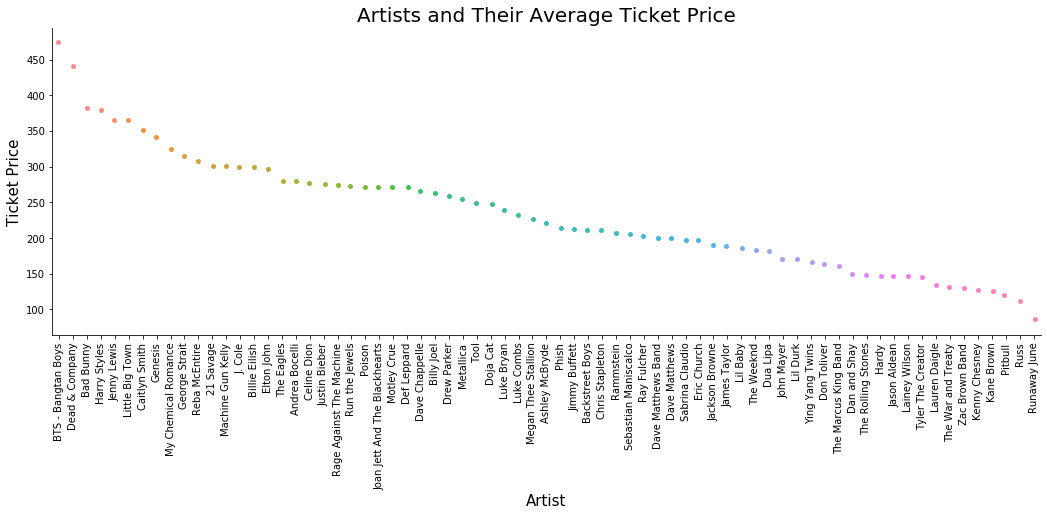

In [41]:
sns.catplot(x='artist', y='price', data=df_artist.reset_index(), height=5, aspect=3)
plt.xticks(rotation='90')
plt.xlabel('Artist', fontsize=15)
plt.ylabel('Ticket Price', fontsize=15)
plt.title('Artists and Their Average Ticket Price', fontsize=20);

#### Top 10 Venues with the Highest Average Ticket Price

In [42]:
df_venue = df_tickets.groupby('venue').mean()['price'].sort_values(ascending=False)
df_venue.head()

venue
The Colosseum At Caesars Palace    345.885122
SoFi Stadium                       316.754525
Fenway Park                        303.338663
Barclays Center                    291.907937
Capital One Arena                  284.221477
Name: price, dtype: float64

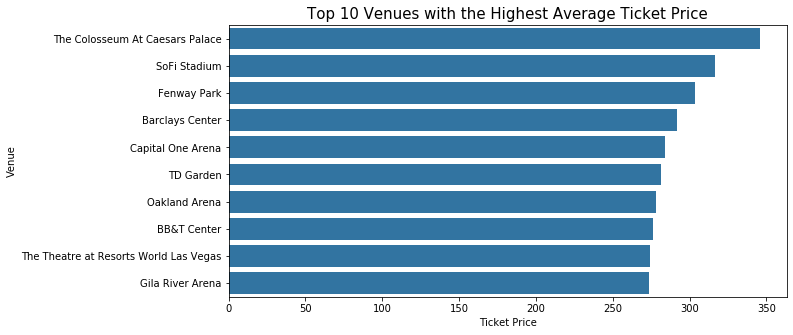

In [43]:
plt.figure(figsize=(10,5))
sns.barplot(y=df_venue.index[:10], x=df_venue[:10], color=blue)
plt.xlabel('Ticket Price', fontsize=10)
plt.ylabel('Venue', fontsize=10)
plt.title('Top 10 Venues with the Highest Average Ticket Price', fontsize=15);

#### Top 10 Cities with the Highest Average Ticket Price

In [44]:
df_city = df_tickets.groupby('city').mean()['price'].sort_values(ascending=False)
df_city.head()

city
Brooklyn      291.907937
Boston        288.264984
Washington    284.221477
Oakland       278.100139
Sunrise       276.251469
Name: price, dtype: float64

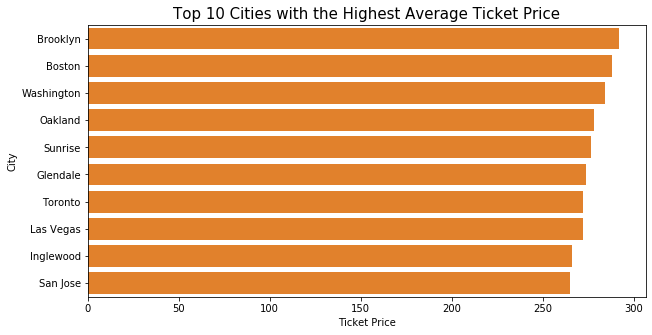

In [45]:
plt.figure(figsize=(10,5))
sns.barplot(y=df_city.index[:10], x=df_city[:10], color=orange)
plt.xlabel('Ticket Price', fontsize=10)
plt.ylabel('City', fontsize=10)
plt.title('Top 10 Cities with the Highest Average Ticket Price', fontsize=15);

#### Top 10 States with the Highest Average Ticket Price

In [46]:
df_state = df_tickets.groupby('state').mean()['price'].sort_values(ascending=False)
df_state.head()

state
MA    288.264984
DC    284.221477
ON    271.878700
NV    271.857270
CT    260.968900
Name: price, dtype: float64

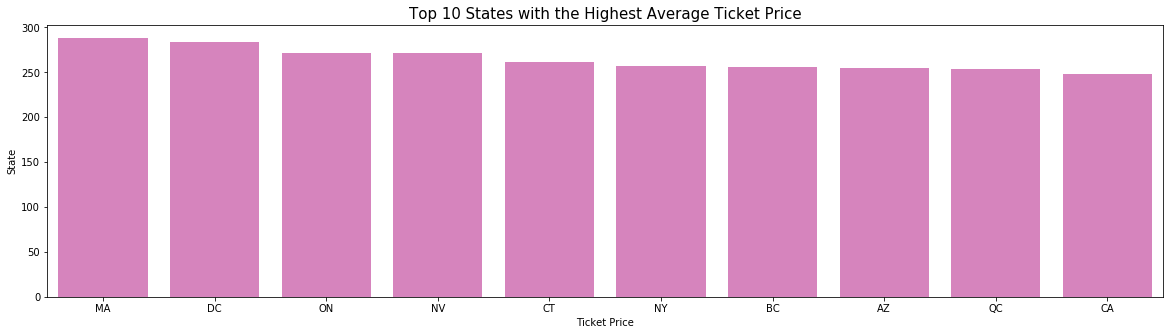

In [47]:
plt.figure(figsize=(20,5))
sns.barplot(x=df_state.index[:10], y=df_state[:10], color=pink)
plt.xlabel('Ticket Price', fontsize=10)
plt.ylabel('State', fontsize=10)
plt.title('Top 10 States with the Highest Average Ticket Price', fontsize=15);

## Salaries Data

In [48]:
#reading file
df_salaries = pd.read_csv('salaries.csv')
df_salaries.columns = ['state','median_salary','avg_salary']
df_salaries

,state,median_salary,avg_salary
0,District of Columbia,"$71,690","$115,923"
1,Massachusetts,"$48,680","$76,437"
2,Alaska,"$48,020","$69,789"
3,Connecticut,"$46,920","$74,405"
4,Washington,"$46,100","$74,016"
5,New York,"$44,990","$80,640"
6,Maryland,"$44,690","$69,893"
7,New Jersey,"$43,600","$71,959"
8,Minnesota,"$42,630","$62,156"
9,Hawaii,"$42,480","$59,231"


In [49]:
df_salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
state            52 non-null object
median_salary    52 non-null object
avg_salary       52 non-null object
dtypes: object(3)
memory usage: 1.3+ KB


In [50]:
#clean the last row
df_salaries['median_salary'][51] = '$20,100'
df_salaries['avg_salary'][51] = df_salaries['median_salary'][51]

In [51]:
#remove dolar sign and convert it to float
df_salaries['median_salary'] = df_salaries['median_salary'].str.replace('$',"").str.replace(",","").astype(float)
df_salaries['avg_salary'] = df_salaries['avg_salary'].str.replace('$',"").str.replace(",","").astype(float)

In [52]:
#dictionary to convert state to abbreviation
state_to_abbrev = {"Alabama": "AL", "Alaska": "AK","Arizona": "AZ","Arkansas": "AR","California": "CA",
                   "Colorado": "CO","Connecticut": "CT","Delaware": "DE","Florida": "FL","Georgia": "GA",
                   "Hawaii": "HI","Idaho": "ID","Illinois": "IL","Indiana": "IN","Iowa": "IA","Kansas": "KS",
                   "Kentucky": "KY","Louisiana": "LA","Maine": "ME","Maryland": "MD","Massachusetts": "MA",
                   "Michigan": "MI","Minnesota": "MN","Mississippi": "MS","Missouri": "MO","Montana": "MT",
                   "Nebraska": "NE","Nevada": "NV","New Hampshire": "NH","New Jersey": "NJ","New Mexico": "NM",
                   "New York": "NY","North Carolina": "NC","North Dakota": "ND","Ohio": "OH","Oklahoma": "OK",
                   "Oregon": "OR","Pennsylvania": "PA","Rhode Island": "RI","South Carolina": "SC",
                   "South Dakota": "SD","Tennessee": "TN","Texas": "TX","Utah": "UT", "Vermont": "VT",
                   "Virginia": "VA","Washington": "WA","West Virginia": "WV","Wisconsin": "WI","Wyoming": "WY",
                   "District of Columbia": "DC","American Samoa": "AS","Guam": "GU","Northern Mariana Islands": "MP",
                   "Puerto Rico": "PR","United States Minor Outlying Islands": "UM","U.S. Virgin Islands": "VI"}

In [53]:
#replacing a state with its abbreviation
df_salaries['state'] = df_salaries['state'].map(state_to_abbrev)

In [54]:
df_salaries.head()

,state,median_salary,avg_salary
0,DC,71690.0,115923.0
1,MA,48680.0,76437.0
2,AK,48020.0,69789.0
3,CT,46920.0,74405.0
4,WA,46100.0,74016.0


## Final Dataset

In [55]:
df = pd.merge(df_tickets, df_salaries, on='state')
df

,artist,level,price,venue,city,state,time,month,year,day,median_salary,avg_salary
0,Machine Gun Kelly,level-0,138.0,Mohegan Sun Arena,Uncasville,CT,19,10,2021,6,46920.0,74405.0
1,Machine Gun Kelly,level-0,147.0,Mohegan Sun Arena,Uncasville,CT,19,10,2021,6,46920.0,74405.0
2,Machine Gun Kelly,level-0,157.0,Mohegan Sun Arena,Uncasville,CT,19,10,2021,6,46920.0,74405.0
3,Machine Gun Kelly,level-0,142.0,Mohegan Sun Arena,Uncasville,CT,19,10,2021,6,46920.0,74405.0
4,Machine Gun Kelly,level-0,221.0,Mohegan Sun Arena,Uncasville,CT,19,10,2021,6,46920.0,74405.0
...,...,...,...,...,...,...,...,...,...,...,...,...
54229,Andrea Bocelli,level-0,442.0,Vivint Smart Home Arena,Salt Lake City,UT,19,10,2021,5,36790.0,54075.0
54230,Andrea Bocelli,level-1,131.0,Vivint Smart Home Arena,Salt Lake City,UT,19,10,2021,5,36790.0,54075.0
54231,Andrea Bocelli,level-0,469.0,Vivint Smart Home Arena,Salt Lake City,UT,19,10,2021,5,36790.0,54075.0
54232,Andrea Bocelli,level-0,444.0,Vivint Smart Home Arena,Salt Lake City,UT,19,10,2021,5,36790.0,54075.0


In [56]:
#for later use
df_copy = df.copy()

### Creating binary column for classification

In [57]:
df['price_class'] = df.price
df['price_class'][df['price'] >= df.price.mean()] = 1 #'Expensive'
df['price_class'][df['price'] < df.price.mean()] =  0 #'Cheap'

df.price_class.value_counts()

0.0    31858
1.0    22376
Name: price_class, dtype: int64

In [58]:
#trying to see if we can predict for one level
#df = df[df.level == 'GA']

In [59]:
df.columns

Index(['artist', 'level', 'price', 'venue', 'city', 'state', 'time', 'month',
       'year', 'day', 'median_salary', 'avg_salary', 'price_class'],
      dtype='object')

In [60]:
#final clean dataset -> used to visualize in Tableau
df.to_csv('Concert_Tickets.csv', index= False)

### Encode the Categorical Variables 

In [61]:
le = preprocessing.LabelEncoder()
le.fit(df.artist)
df.artist = list(le.transform(df.artist)) 

In [62]:
le = preprocessing.LabelEncoder()
le.fit(df.venue)
df.venue = list(le.transform(df.venue)) 

In [63]:
le = preprocessing.LabelEncoder()
le.fit(df.city)
df.city = list(le.transform(df.city)) 

In [64]:
le = preprocessing.LabelEncoder()
le.fit(df.state)
df.state = list(le.transform(df.state)) 

In [65]:
le = preprocessing.LabelEncoder()
le.fit(df.level)
df.level = list(le.transform(df.level)) 

In [66]:
df

,artist,level,price,venue,city,state,time,month,year,day,median_salary,avg_salary,price_class
0,45,54,138.0,32,49,3,19,10,2021,6,46920.0,74405.0,0.0
1,45,54,147.0,32,49,3,19,10,2021,6,46920.0,74405.0,0.0
2,45,54,157.0,32,49,3,19,10,2021,6,46920.0,74405.0,0.0
3,45,54,142.0,32,49,3,19,10,2021,6,46920.0,74405.0,0.0
4,45,54,221.0,32,49,3,19,10,2021,6,46920.0,74405.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54229,1,54,442.0,57,38,25,19,10,2021,5,36790.0,54075.0,1.0
54230,1,55,131.0,57,38,25,19,10,2021,5,36790.0,54075.0,0.0
54231,1,54,469.0,57,38,25,19,10,2021,5,36790.0,54075.0,1.0
54232,1,54,444.0,57,38,25,19,10,2021,5,36790.0,54075.0,1.0


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54234 entries, 0 to 54233
Data columns (total 13 columns):
artist           54234 non-null int64
level            54234 non-null int64
price            54234 non-null float64
venue            54234 non-null int64
city             54234 non-null int64
state            54234 non-null int64
time             54234 non-null int64
month            54234 non-null int64
year             54234 non-null int64
day              54234 non-null int64
median_salary    54234 non-null float64
avg_salary       54234 non-null float64
price_class      54234 non-null float64
dtypes: float64(4), int64(9)
memory usage: 5.8 MB


### Correlation Between the Variables

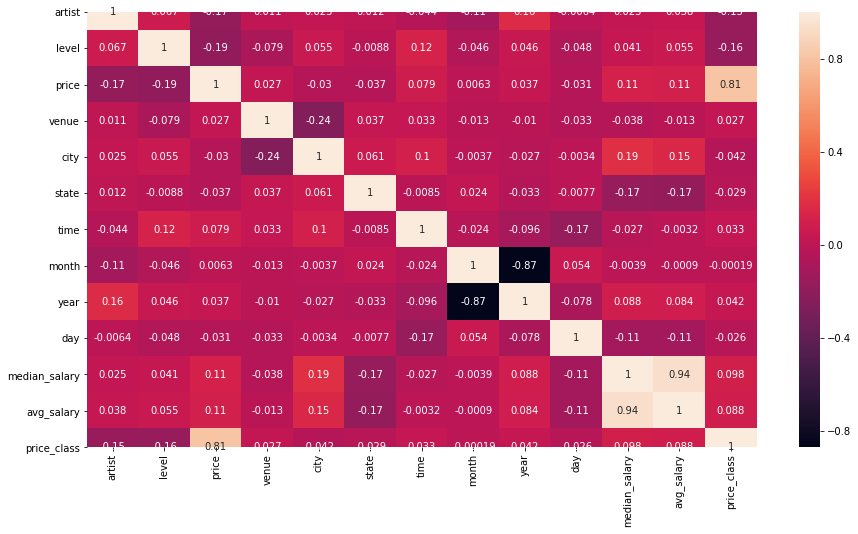

In [68]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot = True);

In [69]:
df.columns

Index(['artist', 'level', 'price', 'venue', 'city', 'state', 'time', 'month',
       'year', 'day', 'median_salary', 'avg_salary', 'price_class'],
      dtype='object')

## Regression

In [70]:
features = ['artist', 'level', 'venue', 'city', 'state', 'day','time', 'month', 'year', 'median_salary', 'avg_salary']
X = df[features]
y = df.price

# split 80% of the data to the training set while 20% of the data to test set
#X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20) 
# split 75% of the data to the training set while 25% of the data to validation set
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25)

### Linear Regression

In [71]:
def LinReg(X_train, y_train, X_val, y_val):
    model = LinearRegression(random_state = 1)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    r_squared = model.score(X_val, y_val)
    MAE_ = metrics.mean_absolute_error(y_val, y_pred)
    MSE_ = metrics.mean_squared_error(y_val, y_pred)
    RMSE_ = np.sqrt(MSE_)
    return [r_squared, MAE_, MSE_, RMSE_]

### Polynomial Features

In [72]:
def Polynomial(X_train, y_train, X_val, y_val, degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression(), random_state = 1)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    r_squared = model.score(X_val, y_val)
    MAE_ = metrics.mean_absolute_error(y_val, y_pred)
    MSE_ = metrics.mean_squared_error(y_val, y_pred)
    RMSE_ = np.sqrt(MSE_)
    return [r_squared, MAE_, MSE_, RMSE_]

In [73]:
results = {}
#for i in tqdm(range(2,6)): # 1 is the normal linear regression
#    results[i]  = Polynomial(X_train, y_train, X_val, y_val, i)

### Decision Tree Regressor

In [74]:
def DTree(X_train, y_train, X_val, y_val, depth):
    model = DecisionTreeRegressor(max_depth= depth, random_state = 1)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    r_squared = model.score(X_val, y_val)
    MAE_ = metrics.mean_absolute_error(y_val, y_pred)
    MSE_ = metrics.mean_squared_error(y_val, y_pred)
    RMSE_ = np.sqrt(MSE_)
    return [r_squared, MAE_, MSE_, RMSE_]

### Ada Boost Regressor

In [75]:
def AdaBoost_Reg(X_train, y_train, X_val, y_val, n_estimators, depth):
    #n_estimators: The number of trees in the forest. -> default = 100
    model = AdaBoostRegressor(DecisionTreeRegressor(max_depth= depth), n_estimators = n_estimators, random_state = 1)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    r_squared = model.score(X_val, y_val)
    MAE_ = metrics.mean_absolute_error(y_val, y_pred)
    MSE_ = metrics.mean_squared_error(y_val, y_pred)
    RMSE_ = np.sqrt(MSE_)
    return [r_squared, MAE_, MSE_, RMSE_]

### Random Forest Regressor

In [76]:
def RandForest_Reg(X_train, y_train, X_val, y_val, depth):
    model = RandomForestRegressor(max_depth= depth, random_state = 1)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    r_squared = model.score(X_val, y_val)
    MAE_ = metrics.mean_absolute_error(y_val, y_pred)
    MSE_ = metrics.mean_squared_error(y_val, y_pred)
    RMSE_ = np.sqrt(MSE_)
    return [r_squared, MAE_, MSE_, RMSE_]

In [77]:
'''
def RandForest(X_train, y_train, X_val, y_val):
    train = {}
    val = {}
    val_score = {}
    for i in tqdm(range(1,51)):
        model = RandomForestRegressor(max_depth=i,random_state = 1)
        model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        
        train[i]  = metrics.mean_absolute_error(y_train,y_pred_train)
        val[i]  = metrics.mean_absolute_error(y_val,y_pred_val)
        val_score[i] = metrics.r2_score(y_val,y_pred_val)

    plt.plot(list(train.keys()), list(train.values()), label = 'Train')
    plt.plot(list(val.keys()), list(val.values()),  label = 'Validation')

    plt.xlabel('Depth')
    plt.ylabel('MAE')
    plt.title('MAE for each Depth')
    plt.legend()
    plt.show()
    
    return val_score
 ''';

In [78]:
RandForest_Reg(X_train, y_train, X_test, y_test, 15)[0]

0.7491491906714419

In [79]:
RandForest_Reg(X_train, y_train, X_test, y_test, 16)[0]

0.7534451369658536

In [80]:
RandForest_Reg(X_train, y_train, X_test, y_test, 17)[0]

0.7560729267634285

In [81]:
RandForest_Reg(X_train, y_train, X_test, y_test, 18)[0]

0.7561762988450923

In [82]:
RandForest_Reg(X_train, y_train, X_test, y_test, 19)[0]

0.7571675426937909

### Grid Search CV

In [83]:
#parameters = {'max_depth':(list(range(1,26)))}
#GS = GridSearchCV(RandomForestRegressor(random_state = 1, n_estimators = 100), parameters)
#GS.fit(X_train, y_train)

In [84]:
#GS.best_estimator_

In [85]:
#GS.cv_results_['mean_test_score']

## Classification

#### Splitting the data

In [86]:
features = ['artist', 'level', 'venue', 'city', 'state', 'day','time', 'month', 'year', 'median_salary', 'avg_salary']
X = df[features]
y = df.price_class

# split 80% of the data to the training set while 20% of the data to test set
#X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20) 
# split 75% of the data to the training set while 25% of the data to validation set
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25)

### Logistic Regression

In [87]:
def LogReg(X_train, y_train, X_val, y_val):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model.score(X_val, y_val)

### K Neighbors Classifier

In [88]:
def KNeighbors(X_train, y_train, X_val, y_val):
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    return model.score(X_val, y_val)

### Bagging Classifier

In [89]:
def Bagging(X_train, y_train, X_val, y_val, max_samples, max_features):
    model = BaggingClassifier(KNeighborsClassifier(), max_samples= max_samples, max_features=max_features) #both 0.5 
    model.fit(X_train, y_train)
    return model.score(X_val, y_val)

### Ada Boost Classifier

In [90]:
def AdaBoost_Clf(X_train, y_train, X_val, y_val, n_estimators, depth):
    model = AdaBoostClassifier(DecisionTreeClassifier(n_estimators= n_estimators, max_depth= depth))
    model.fit(X_train, y_train)
    return model.score(X_val, y_val)

### Random Forest Classifier

In [91]:
def RandForest__Clf(X_train, y_train, X_val, y_val, n_estimators):
    model = RandomForestClassifier(n_estimators= n_estimators)
    model.fit(X_train, y_train)
    return model.score(X_val, y_val)

In [92]:
#metrics.confusion_matrix(y_val, model.predict(X_val))

#### Extra

In [93]:
'''
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

r_squared = model.score(X_test, y_test)
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
r_squared , adjusted_r_squared 
''';

In [94]:
#final clean and merged dataset -> used to visualize in Tableau
df_merge = pd.merge(df_copy, df_cities_small, on=['city', 'state'])
df_new = pd.merge(df_merge, df_states_coor, on='state')

In [95]:
df_new.to_csv('big_data.csv', index=False)